## ChIP-Seq and RNA-Seq

We now want to combine our ChIP-Seq and RNA-Seq data, using pandas.

In [1]:
import pandas as pd

### Gene annotations

We can read our GFF file of gene annotations. It's just a text table.

There are no headers, though. The columns of the file are:
```
['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']
```

In [4]:
genes = pd.read_csv("~/shared/MCB280A_data/S288C_R64-3-1/saccharomyces_cerevisiae_R64-3-1_20210421.gff",
                    delimiter='\t', header=None,
                   names=['seqid', 'source', 'type', 'start', 'end',
                          'score', 'strand', 'phase', 'attributes'])
genes.head()

,seqid,source,type,start,end,score,strand,phase,attributes
0,chrI,SGD,telomere,1,801,.,-,.,ID=TEL01L;Name=TEL01L;Note=Telomeric%20region%...
1,chrI,SGD,X_element,337,801,.,-,.,Parent=TEL01L;Name=TEL01L_X_element
2,chrI,SGD,X_element_combinatorial_repeat,63,336,.,-,.,Parent=TEL01L;Name=TEL01L_X_element_combinator...
3,chrI,SGD,telomeric_repeat,1,62,.,-,.,Parent=TEL01L;Name=TEL01L_telomeric_repeat_1
4,chrI,SGD,telomere,1,801,.,-,.,ID=TEL01L_telomere;Name=TEL01L_telomere;Parent...


There are many different "types" of entries in the file. We can use the `value_counts()` method on the `type` column to see all of them.

In [5]:
genes['type'].value_counts()

mRNA                                  11119
CDS                                    7066
gene                                   6607
noncoding_exon                          489
long_terminal_repeat                    384
intron                                  378
tRNA_gene                               299
tRNA                                    299
transposable_element                     91
transposable_element_gene                91
region                                   78
snoRNA                                   77
snoRNA_gene                              77
telomere                                 64
LTR_retrotransposon                      50
plus_1_translational_frameshift          47
X_element                                32
centromere                               32
telomeric_repeat                         31
X_element_combinatorial_repeat           28
rRNA                                     24
five_prime_UTR_intron                    24
rRNA_gene                       

We only want the `"gene"` type of entry and so we'll pick out just these rows out of the data frame.

In [6]:
genes = genes[genes['type'] == "gene"]
genes.head()

,seqid,source,type,start,end,score,strand,phase,attributes
5,chrI,SGD,gene,335,649,.,+,.,ID=YAL069W;Name=YAL069W;Ontology_term=GO:00036...
8,chrI,SGD,gene,538,792,.,+,.,ID=YAL068W-A;Name=YAL068W-A;Ontology_term=GO:0...
11,chrI,SGD,gene,1807,2169,.,-,.,"ID=YAL068C;Name=YAL068C;gene=PAU8;Alias=PAU8,s..."
14,chrI,SGD,gene,2480,2707,.,+,.,ID=YAL067W-A;Name=YAL067W-A;Ontology_term=GO:0...
17,chrI,SGD,gene,7235,9016,.,-,.,"ID=YAL067C;Name=YAL067C;gene=SEO1;Alias=SEO1,p..."


The systematic name of the gene is buried inside the `attributes` column. This column has a bunch of labeled data in the form _key_=_value_.

We can extract it using the `.str.split()` method and then use `.str.replace()` to get rid of the wanted `ID=` part of it to create a `name` column.

In [13]:
genes['name'] = genes['attributes'].str.split(';').str[0].str.replace("ID=", "")
genes.head()

,seqid,source,type,start,end,score,strand,phase,attributes,name
5,chrI,SGD,gene,335,649,.,+,.,ID=YAL069W;Name=YAL069W;Ontology_term=GO:00036...,YAL069W
8,chrI,SGD,gene,538,792,.,+,.,ID=YAL068W-A;Name=YAL068W-A;Ontology_term=GO:0...,YAL068W-A
11,chrI,SGD,gene,1807,2169,.,-,.,"ID=YAL068C;Name=YAL068C;gene=PAU8;Alias=PAU8,s...",YAL068C
14,chrI,SGD,gene,2480,2707,.,+,.,ID=YAL067W-A;Name=YAL067W-A;Ontology_term=GO:0...,YAL067W-A
17,chrI,SGD,gene,7235,9016,.,-,.,"ID=YAL067C;Name=YAL067C;gene=SEO1;Alias=SEO1,p...",YAL067C


The data table lists the coordinates of genes, but we want to look for ChIP-Seq peaks in the promoter regions. For a `+` strand gene, the promoter is to the left (smaller coordinate numbers) and for a `-` strand gene it is to the right.

We'll use a 1 kb window here.

For a `+` strand gene, the promoter is _start_-1000 to _start_-1.

For a `-` strand gene, the promoter is _end_+1 to _end_+1000.

We can use the `np.where(...)` function from `numpy` to handle this situation. We'll compute the starting position for each promoter in the `prmstart` column.

In [15]:
import numpy as np
genes['prmstart'] = np.where(genes['strand'] == "+", 
         genes['start'] - 1000,
         genes['end'] + 1)
genes.head()

,seqid,source,type,start,end,score,strand,phase,attributes,name,prmstart
5,chrI,SGD,gene,335,649,.,+,.,ID=YAL069W;Name=YAL069W;Ontology_term=GO:00036...,YAL069W,-665
8,chrI,SGD,gene,538,792,.,+,.,ID=YAL068W-A;Name=YAL068W-A;Ontology_term=GO:0...,YAL068W-A,-462
11,chrI,SGD,gene,1807,2169,.,-,.,"ID=YAL068C;Name=YAL068C;gene=PAU8;Alias=PAU8,s...",YAL068C,2170
14,chrI,SGD,gene,2480,2707,.,+,.,ID=YAL067W-A;Name=YAL067W-A;Ontology_term=GO:0...,YAL067W-A,1480
17,chrI,SGD,gene,7235,9016,.,-,.,"ID=YAL067C;Name=YAL067C;gene=SEO1;Alias=SEO1,p...",YAL067C,9017


We'll be sure to check our coordinate math for genes on each strand.

Next, we'll make a `prmend` column that is 1000 bases after the start. We don't need to do anything different based on the strand here.

In [17]:
genes['prmend'] = genes['prmstart'] + 999
genes.head()

,seqid,source,type,start,end,score,strand,phase,attributes,name,prmstart,prmend
5,chrI,SGD,gene,335,649,.,+,.,ID=YAL069W;Name=YAL069W;Ontology_term=GO:00036...,YAL069W,-665,334
8,chrI,SGD,gene,538,792,.,+,.,ID=YAL068W-A;Name=YAL068W-A;Ontology_term=GO:0...,YAL068W-A,-462,537
11,chrI,SGD,gene,1807,2169,.,-,.,"ID=YAL068C;Name=YAL068C;gene=PAU8;Alias=PAU8,s...",YAL068C,2170,3169
14,chrI,SGD,gene,2480,2707,.,+,.,ID=YAL067W-A;Name=YAL067W-A;Ontology_term=GO:0...,YAL067W-A,1480,2479
17,chrI,SGD,gene,7235,9016,.,-,.,"ID=YAL067C;Name=YAL067C;gene=SEO1;Alias=SEO1,p...",YAL067C,9017,10016


### ChIP-Seq Peaks

Now, we'll read in the table of ChIP-Seq peaks.

In [18]:
peaks = pd.read_csv("~/Hsf1/ChIP-Seq/macs2/Hsf1_ChIP_heatshk_peaks.xls",
                    delimiter = '\t', comment = '#')
peaks.head()

,chr,start,end,length,abs_summit,pileup,-log10(pvalue),fold_enrichment,-log10(qvalue),name
0,chrI,23546,23755,210,23733,50,9.64499,2.65601,7.55540,Hsf1_ChIP_heatshk_peak_1
1,chrI,71056,71337,282,71176,65,7.96768,2.12219,5.99254,Hsf1_ChIP_heatshk_peak_2
2,chrI,71873,73595,1723,72380,89,18.71100,2.97030,16.18150,Hsf1_ChIP_heatshk_peak_3
3,chrI,101112,101311,200,101291,45,7.47097,2.39562,5.53262,Hsf1_ChIP_heatshk_peak_4
4,chrI,139663,141017,1355,140367,103,9.85628,1.96375,7.75715,Hsf1_ChIP_heatshk_peak_5


At this point we need to loop over each peak and find out which promoter(s) it affects.

We'll do this in a multi-step process.
1. Generate a dictionary where keys are gene names and values are associated ChIP-Seq peak names. There won't be an entry for every gene.
1. Convert this dictionary into a pandas `Series` and merge it in to a new column of the genes data frame, holding peak names. It will have many `NaN` entries for "missing" data.
1. Merge the whole table of peaks (with enrichment and p-values) into the gene table based on the names.

First, we will loop over each peak, using the `.itertuples()` method. In class, we'll just use the top 10 peaks by significance.

In [22]:
gene_peaks = {}
top_peaks = peaks.sort_values('fold_enrichment', ascending=False).head(10)
for peak in top_peaks.itertuples():
    for gene in genes.itertuples():
        if (peak.chr == gene.seqid) and (peak.abs_summit >= gene.prmstart) and (peak.abs_summit <= gene.prmend):
            gene_peaks[gene.name] = peak.name
gene_peaks

{'YGR210C': 'Hsf1_ChIP_heatshk_peak_389',
 'YGR211W': 'Hsf1_ChIP_heatshk_peak_389',
 'YBR101C': 'Hsf1_ChIP_heatshk_peak_69',
 'YGR142W': 'Hsf1_ChIP_heatshk_peak_372',
 'YPL250C': 'Hsf1_ChIP_heatshk_peak_802',
 'YPL250W-A': 'Hsf1_ChIP_heatshk_peak_802',
 'YLR162W-A': 'Hsf1_ChIP_heatshk_peak_559',
 'YDR258C': 'Hsf1_ChIP_heatshk_peak_167',
 'YNL007C': 'Hsf1_ChIP_heatshk_peak_708',
 'YNL006W': 'Hsf1_ChIP_heatshk_peak_708',
 'YDR214W': 'Hsf1_ChIP_heatshk_peak_162',
 'YER103W': 'Hsf1_ChIP_heatshk_peak_276'}

Now we need to convert this into a `Series` and give it a name.

In [23]:
gene_peaks = pd.Series(gene_peaks, name='peak')
gene_peaks

YGR210C      Hsf1_ChIP_heatshk_peak_389
YGR211W      Hsf1_ChIP_heatshk_peak_389
YBR101C       Hsf1_ChIP_heatshk_peak_69
YGR142W      Hsf1_ChIP_heatshk_peak_372
YPL250C      Hsf1_ChIP_heatshk_peak_802
YPL250W-A    Hsf1_ChIP_heatshk_peak_802
YLR162W-A    Hsf1_ChIP_heatshk_peak_559
YDR258C      Hsf1_ChIP_heatshk_peak_167
YNL007C      Hsf1_ChIP_heatshk_peak_708
YNL006W      Hsf1_ChIP_heatshk_peak_708
YDR214W      Hsf1_ChIP_heatshk_peak_162
YER103W      Hsf1_ChIP_heatshk_peak_276
Name: peak, dtype: object

We can merge our named `Series` into the data frame of genes. We want to match up the `name` column in the genes table with the "index" of the `Series.

In [24]:
genes2 = pd.merge(genes, gene_peaks,
                  left_on='name', right_index=True, how='left')
genes2.head()

,seqid,source,type,start,end,score,strand,phase,attributes,name,prmstart,prmend,peak
5,chrI,SGD,gene,335,649,.,+,.,ID=YAL069W;Name=YAL069W;Ontology_term=GO:00036...,YAL069W,-665,334,NaN
8,chrI,SGD,gene,538,792,.,+,.,ID=YAL068W-A;Name=YAL068W-A;Ontology_term=GO:0...,YAL068W-A,-462,537,NaN
11,chrI,SGD,gene,1807,2169,.,-,.,"ID=YAL068C;Name=YAL068C;gene=PAU8;Alias=PAU8,s...",YAL068C,2170,3169,NaN
14,chrI,SGD,gene,2480,2707,.,+,.,ID=YAL067W-A;Name=YAL067W-A;Ontology_term=GO:0...,YAL067W-A,1480,2479,NaN
17,chrI,SGD,gene,7235,9016,.,-,.,"ID=YAL067C;Name=YAL067C;gene=SEO1;Alias=SEO1,p...",YAL067C,9017,10016,NaN


To make sure this worked, check on the row for the gene `YAL005C`, which does have a peak.

In [25]:
genes2[genes2['name'] == "YGR210C"]

,seqid,source,type,start,end,score,strand,phase,attributes,name,prmstart,prmend,peak
10702,chrVII,SGD,gene,913503,914738,.,-,.,ID=YGR210C;Name=YGR210C;Ontology_term=GO:00036...,YGR210C,914739,915738,Hsf1_ChIP_heatshk_peak_389


Now, we will merge in the peaks table by matching up the `peak` column with the `name` column in the peaks table.

In [26]:
genes3 = pd.merge(genes2, peaks,
                  left_on='peak', right_on='name', how='left')
genes3.head()

,seqid,source,type,start_x,end_x,score,strand,phase,attributes,name_x,...,chr,start_y,end_y,length,abs_summit,pileup,-log10(pvalue),fold_enrichment,-log10(qvalue),name_y
0,chrI,SGD,gene,335,649,.,+,.,ID=YAL069W;Name=YAL069W;Ontology_term=GO:00036...,YAL069W,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chrI,SGD,gene,538,792,.,+,.,ID=YAL068W-A;Name=YAL068W-A;Ontology_term=GO:0...,YAL068W-A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chrI,SGD,gene,1807,2169,.,-,.,"ID=YAL068C;Name=YAL068C;gene=PAU8;Alias=PAU8,s...",YAL068C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chrI,SGD,gene,2480,2707,.,+,.,ID=YAL067W-A;Name=YAL067W-A;Ontology_term=GO:0...,YAL067W-A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chrI,SGD,gene,7235,9016,.,-,.,"ID=YAL067C;Name=YAL067C;gene=SEO1;Alias=SEO1,p...",YAL067C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Again, we'll need to check on a row that has a peak to be sure it worked.

In [28]:
genes3[genes3['name_x'] == "YGR210C"]

,seqid,source,type,start_x,end_x,score,strand,phase,attributes,name_x,...,chr,start_y,end_y,length,abs_summit,pileup,-log10(pvalue),fold_enrichment,-log10(qvalue),name_y
2547,chrVII,SGD,gene,913503,914738,.,-,.,ID=YGR210C;Name=YGR210C;Ontology_term=GO:00036...,YGR210C,...,chrVII,914726.0,915341.0,616.0,915027.0,321.0,235.086,12.8594,229.177,Hsf1_ChIP_heatshk_peak_389


### RNA-Seq data

Finally, we're ready to read in the table of RNA-Seq results.

In [29]:
results = pd.read_csv("~/Hsf1/RNA-Seq/full.results.csv",
                      index_col = 0)
results.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Q0010,0.0,NaN,NaN,NaN,NaN,NaN
Q0017,0.0,NaN,NaN,NaN,NaN,NaN
Q0032,0.0,NaN,NaN,NaN,NaN,NaN
Q0045,0.0,NaN,NaN,NaN,NaN,NaN
Q0050,0.0,NaN,NaN,NaN,NaN,NaN


Again we can pull out some statistically significant genes to be sure it worked. Notice that almost every significant gene is down-regulated.

In [30]:
results[results['padj'] < 0.1]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
YAL005C,4973.736731,-2.831197,0.269331,-10.511978,7.608047e-26,1.211011e-22
YBR067C,6601.912986,-1.598963,0.373009,-4.286660,1.813795e-05,7.698954e-03
YBR101C,3528.512278,-1.215401,0.289295,-4.201254,2.654410e-05,1.056289e-02
YDR214W,3436.341557,-1.875259,0.301106,-6.227899,4.727310e-10,3.762348e-07
YDR216W,1048.683844,-1.567399,0.364029,-4.305702,1.664567e-05,7.570215e-03
YDR258C,1290.992019,-1.464184,0.325875,-4.493090,7.019698e-06,3.438032e-03
YFR036W-A,64.658953,2.234114,0.564499,3.957693,7.567706e-05,2.676866e-02
YGR142W,420.520506,-1.922651,0.368085,-5.223394,1.756733e-07,1.016829e-04
YJR046W,1326.102238,-1.134671,0.313169,-3.623187,2.909957e-04,9.263849e-02
YLL024C,47370.552792,-4.455708,0.259150,-17.193563,2.967229e-66,1.889235e-62


Finally, we're ready to merge the results with the genes.

We'll match up the `name_x` column of the genes (which was renamed because the peak table also had a name column) with the "index" of the results table.

In [32]:
genes4 = pd.merge(genes3, results,
                  left_on='name_x', right_index=True, how='left')
genes4.head()

,seqid,source,type,start_x,end_x,score,strand,phase,attributes,name_x,...,-log10(pvalue),fold_enrichment,-log10(qvalue),name_y,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,chrI,SGD,gene,335,649,.,+,.,ID=YAL069W;Name=YAL069W;Ontology_term=GO:00036...,YAL069W,...,NaN,NaN,NaN,NaN,0.478392,2.265198,4.888960,0.463329,0.643128,0.999885
1,chrI,SGD,gene,538,792,.,+,.,ID=YAL068W-A;Name=YAL068W-A;Ontology_term=GO:0...,YAL068W-A,...,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
2,chrI,SGD,gene,1807,2169,.,-,.,"ID=YAL068C;Name=YAL068C;gene=PAU8;Alias=PAU8,s...",YAL068C,...,NaN,NaN,NaN,NaN,1.061544,-3.645244,3.762115,-0.968935,0.332578,0.999885
3,chrI,SGD,gene,2480,2707,.,+,.,ID=YAL067W-A;Name=YAL067W-A;Ontology_term=GO:0...,YAL067W-A,...,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
4,chrI,SGD,gene,7235,9016,.,-,.,"ID=YAL067C;Name=YAL067C;gene=SEO1;Alias=SEO1,p...",YAL067C,...,NaN,NaN,NaN,NaN,123.571978,0.221327,0.419384,0.527743,0.597678,0.999885


Let's check out the ChIP-Seq genes in the RNA-Seq data.

In [33]:
genes4.sort_values('fold_enrichment', ascending=False).head()

,seqid,source,type,start_x,end_x,score,strand,phase,attributes,name_x,...,-log10(pvalue),fold_enrichment,-log10(qvalue),name_y,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
2547,chrVII,SGD,gene,913503,914738,.,-,.,ID=YGR210C;Name=YGR210C;Ontology_term=GO:00036...,YGR210C,...,235.086,12.8594,229.177,Hsf1_ChIP_heatshk_peak_389,1465.764956,-0.054162,0.293441,-0.184576,8.535615e-01,0.999885
2548,chrVII,SGD,gene,915241,916701,.,+,.,"ID=YGR211W;Name=YGR211W;gene=ZPR1;Alias=ZPR1,z...",YGR211W,...,235.086,12.8594,229.177,Hsf1_ChIP_heatshk_peak_389,5726.838885,-0.687502,0.293452,-2.342811,1.913905e-02,0.999885
349,chrII,SGD,gene,443821,444693,.,-,.,ID=YBR101C;Name=YBR101C;gene=FES1;Alias=FES1;O...,YBR101C,...,158.552,10.6449,154.402,Hsf1_ChIP_heatshk_peak_69,3528.512278,-1.215401,0.289295,-4.201254,2.654410e-05,0.010563
2474,chrVII,SGD,gene,772454,773686,.,+,.,ID=YGR142W;Name=YGR142W;gene=BTN2;Alias=BTN2;O...,YGR142W,...,186.912,10.2962,182.373,Hsf1_ChIP_heatshk_peak_372,420.520506,-1.922651,0.368085,-5.223394,1.756733e-07,0.000102
6101,chrXVI,SGD,gene,74309,74719,.,-,.,ID=YPL250C;Name=YPL250C;gene=ATG41;Alias=ATG41...,YPL250C,...,172.006,10.1810,167.709,Hsf1_ChIP_heatshk_peak_802,1333.907690,0.020420,0.314142,0.065002,9.481720e-01,0.999885


Of course, most genes have a `NaN` missing value for fold enrichment. We can use the `pd.isna()` function to test whether a value is `NaN` or not.

Rows where `fold_enrichment` is _not_ `NaN` are genes with a potential ChIP-Seq peak.

In [35]:
pd.isna(genes4['fold_enrichment']).value_counts()

True     6595
False      12
Name: fold_enrichment, dtype: int64

Many of these genes have significant adjusted p-values and negative log fold-changes. Let's look at this trend more rigorously by plotting the histogram of fold-changes for these groups.

Start by importing matplotlib.pyplot.

In [36]:
import matplotlib.pyplot as plt

We'll make a histogram of `fold_enrichment` values for all genes.

(array([   6.,   12.,   23.,   71.,  500., 5432.,  232.,   54.,   27.,
          10.]),
 array([-5.21510413, -4.23470041, -3.25429669, -2.27389297, -1.29348925,
        -0.31308553,  0.66731819,  1.64772191,  2.62812563,  3.60852935,
         4.58893308]),
 <BarContainer object of 10 artists>)

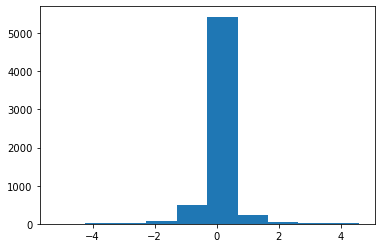

In [37]:
plt.hist(genes4['log2FoldChange'])

Then, we'll make a similar histogram, for genes with a ChIP-Seq peak.

We'll use the `range` parameter so the histograms are easier to compare.

(array([0., 1., 2., 2., 4., 2., 0., 1., 0., 0.]),
 array([-4. , -3.2, -2.4, -1.6, -0.8,  0. ,  0.8,  1.6,  2.4,  3.2,  4. ]),
 <BarContainer object of 10 artists>)

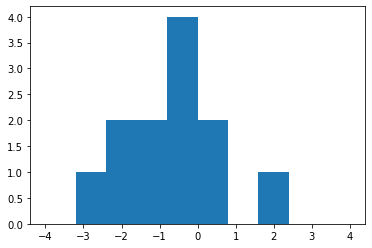

In [40]:
genes_with_peak = genes4[~pd.isna(genes4['fold_enrichment'])]
plt.hist(genes_with_peak['log2FoldChange'], range=(-4,4))

This looks different—but is it significant?

We'll use the `mannwhitneyu` function from `scipy.stats` to run a statistical test. To do this, we'll need to remove the `NaN` values using the `.dropna()` method.

In [41]:
import scipy.stats as stats

nochip = genes4[pd.isna(genes4['fold_enrichment'])]['log2FoldChange'].dropna()
yeschip = genes4[~pd.isna(genes4['fold_enrichment'])]['log2FoldChange'].dropna()

stats.mannwhitneyu(nochip, yeschip)

MannwhitneyuResult(statistic=58374.0, pvalue=0.0014616513606629151)

Finally, we'll make a table of the high-confidence targets that have a ChIP-Seq peak and an expression change.

In [42]:
targets = genes4[(~pd.isna(genes4['fold_enrichment']))
                 & (genes4['padj'] < 0.1)]
targets

,seqid,source,type,start_x,end_x,score,strand,phase,attributes,name_x,...,-log10(pvalue),fold_enrichment,-log10(qvalue),name_y,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
349,chrII,SGD,gene,443821,444693,.,-,.,ID=YBR101C;Name=YBR101C;gene=FES1;Alias=FES1;O...,YBR101C,...,158.552,10.64490,154.402,Hsf1_ChIP_heatshk_peak_69,3528.512278,-1.215401,0.289295,-4.201254,2.654410e-05,1.056289e-02
1243,chrIV,SGD,gene,892875,893927,.,+,.,ID=YDR214W;Name=YDR214W;gene=AHA1;Alias=AHA1;O...,YDR214W,...,117.605,9.47421,113.817,Hsf1_ChIP_heatshk_peak_162,3436.341557,-1.875259,0.301106,-6.227899,4.727310e-10,3.762348e-07
1288,chrIV,SGD,gene,971808,974243,.,-,.,ID=YDR258C;Name=YDR258C;gene=HSP78;Alias=HSP78...,YDR258C,...,130.964,9.92330,127.060,Hsf1_ChIP_heatshk_peak_167,1290.992019,-1.464184,0.325875,-4.493090,7.019698e-06,3.438032e-03
2474,chrVII,SGD,gene,772454,773686,.,+,.,ID=YGR142W;Name=YGR142W;gene=BTN2;Alias=BTN2;O...,YGR142W,...,186.912,10.29620,182.373,Hsf1_ChIP_heatshk_peak_372,420.520506,-1.922651,0.368085,-5.223394,1.756733e-07,1.016829e-04
5382,chrXIV,SGD,gene,618507,619565,.,-,.,"ID=YNL007C;Name=YNL007C;gene=SIS1;Alias=SIS1,t...",YNL007C,...,186.175,9.87451,181.642,Hsf1_ChIP_heatshk_peak_708,1067.866637,-2.608539,0.292907,-8.905696,5.305227e-19,6.755676e-16
